# Imports

In [1]:
import os
import cv2
import stat
import dill
import wandb
import shutil
import tempfile
import pandas as pd

from pathlib import Path
from fastai.torch_core import set_seed
from fastai.learner import Learner

import project_config as pc
import evaluation_config as ec
from training_config import config as tc

cv2.setNumThreads(0)

c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Retrieve dataset

In [ ]:
# Init run
run = wandb.init(project=pc.WANDB_PROJECT,
				 entity=pc.WANDB_ENTITY,
				 dir=pc.WANDB_LOCAL_LOGS_PATH,
				 job_type='model_training',
				 config=tc)

# Download latest dataset version (if not already downloaded)
dataset_artifact = run.use_artifact(f'{pc.DATASET_ARTIFACT_NAME}:latest')
dataset_dir = pc.WANDB_LOCAL_ARTIFACTS_PATH+Path(dataset_artifact._default_root()).stem
if not os.path.exists(dataset_dir):
	_ = dataset_artifact.download(root=dataset_dir)

wandb: Currently logged in as: facuroffet99 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [3]:
# Read dataframe and add full file paths
df = pd.read_csv(dataset_dir+'/dataset.csv')
df['file_path'] = df['file_path'].apply(lambda x: dataset_dir+'/'+x)
df

,file_path,group,label_breed,label_animal,is_valid
0,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/american_bulldog_10.jpg,10,american_bulldog,dog,False
1,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/american_bulldog_100.jpg,100,american_bulldog,dog,False
2,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/american_bulldog_101.jpg,101,american_bulldog,dog,True
3,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/american_bulldog_102.jpg,102,american_bulldog,dog,False
4,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/american_bulldog_103.jpg,103,american_bulldog,dog,False
...,...,...,...,...,...
6425,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/yorkshire_terrier_94.jpg,94,yorkshire_terrier,dog,False
6426,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/yorkshire_terrier_95.jpg,95,yorkshire_terrier,dog,True
6427,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/yorkshire_terrier_97.jpg,97,yorkshire_terrier,dog,False
6428,C:/Users/Facu/Documents/wandb/artifacts/oxford-iiit-pet-v3/images/yorkshire_terrier_98.jpg,98,yorkshire_terrier,dog,True


# Data setup

In [4]:
set_seed(tc.SEED, reproducible=True)

# Datablock
block = tc.DATABLOCK

# Dataloaders
dls = block.dataloaders(df, bs=tc.BS, shuffle=True)
dls.rng.seed(tc.SEED)

# Sanity check
n_out = dls.c
print('Number of outputs: ', n_out)

Number of outputs:  1


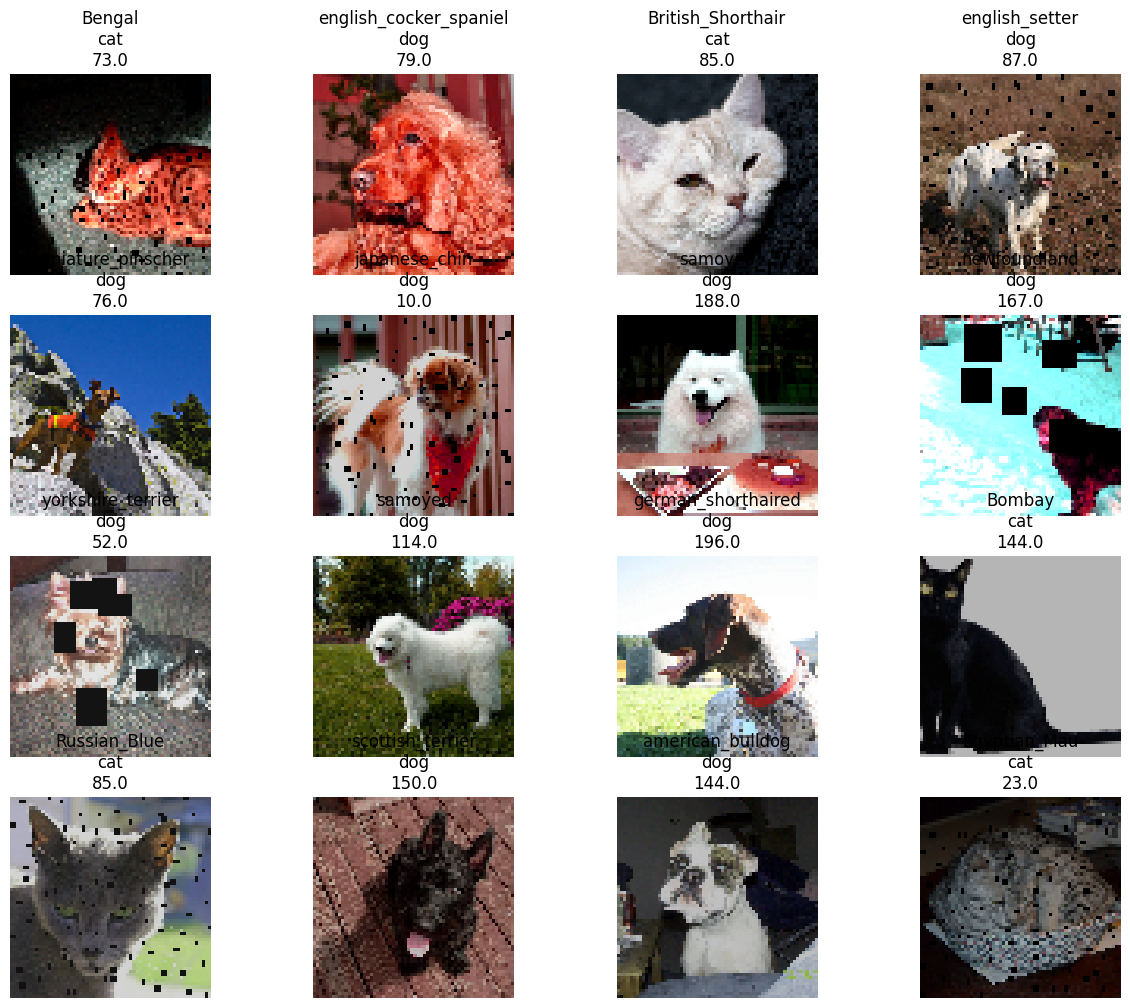

In [5]:
# Show train batch
dls.train.show_batch(max_n=16, figsize=(15,12))

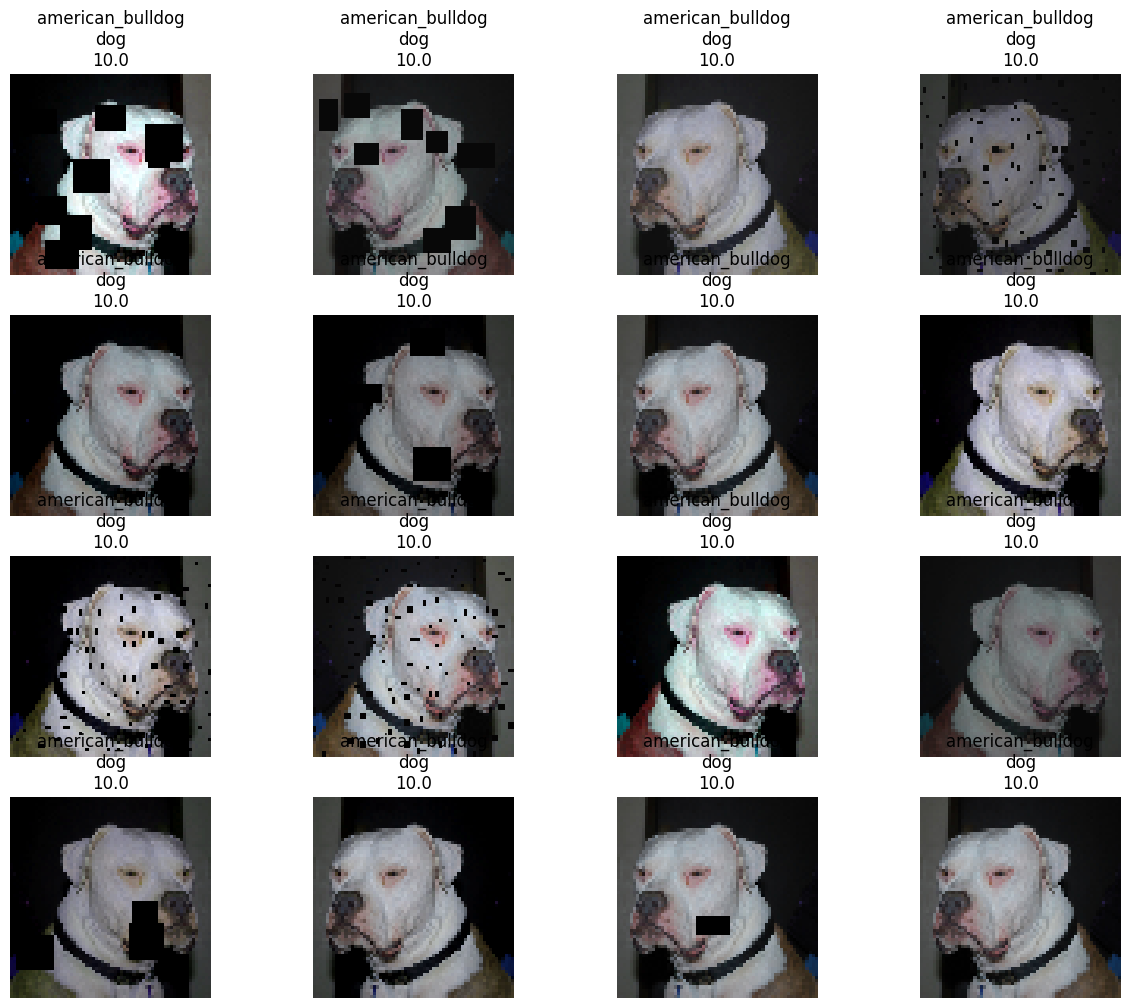

In [6]:
# Show transforms
dls.train.show_batch(max_n=16, unique=True, figsize=(15,12))

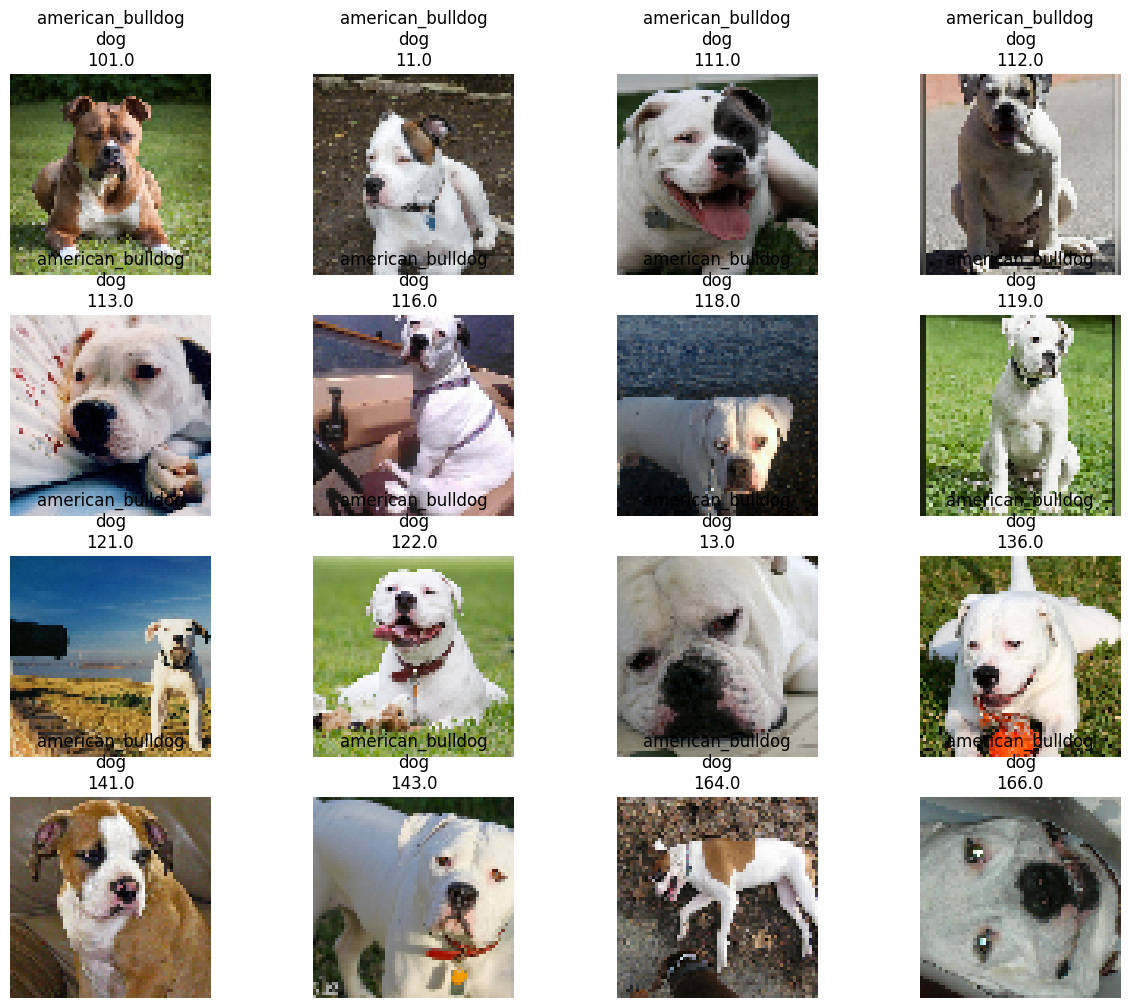

In [7]:
# Show valid batch
dls.valid.show_batch(max_n=16, figsize=(15,12))

# Model setup

In [8]:
from DLOlympus.fastai.imbalanced import get_class_weights, set_controlled_oversampling

# Apply class weights configuration
for i,c in enumerate(tc.CLASS_WEIGHTS_CONFIGS):
	if c is not None:
		tc.LOSS.loss_functions[i].weights = get_class_weights(dls, **c)

# Create and freeze learner
learn = Learner(dls=dls,
				model=tc.MODEL,
				loss_func=tc.LOSS,
				opt_func=tc.OPTIMIZER,
				splitter=tc.SPLITTER,
				metrics=tc.METRICS,
				wd=tc.WD,).to_fp16()
if tc.PRETRAINED: 
	learn.freeze()

# Apply oversampling configuration
if tc.OVERSAMPLING_LABEL is not None:
	learn = set_controlled_oversampling(learn, col=tc.OVERSAMPLING_LABEL)

{'german_shorthaired: 0.9950', 'english_cocker_spaniel: 0.9950', 'British_Shorthair: 1.0170', 'Maine_Coon: 0.9809', 'newfoundland: 0.9950', 'keeshond: 0.9950', 'pomeranian: 0.9950', 'leonberger: 0.9950', 'Bombay: 1.0245', 'chihuahua: 0.9950', 'basset_hound: 0.9950', 'Ragdoll: 0.9879', 'boxer: 0.9950', 'Russian_Blue: 1.0399', 'shiba_inu: 1.0095', 'staffordshire_bull_terrier: 1.0478', 'scottish_terrier: 0.9950', 'english_setter: 0.9950', 'miniature_pinscher: 0.9950', 'Persian: 1.0170', 'Egyptian_Mau: 0.9950', 'pug: 0.9879', 'american_pit_bull_terrier: 1.0095', 'great_pyrenees: 0.9950', 'Siamese: 0.9809', 'Birman: 1.0022', 'samoyed: 0.9879', 'saint_bernard: 0.9950', 'Sphynx: 1.0022', 'havanese: 0.9950', 'Bengal: 1.0022', 'yorkshire_terrier: 0.9950', 'japanese_chin: 0.9950', 'american_bulldog: 1.0095', 'beagle: 0.9950', 'wheaten_terrier: 0.9950'}
{'cat: 0.0100', 'dog: 0.0100'}
Oversampling configured.


# Training

c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings

c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **

SuggestedLRs(valley=0.001737800776027143)

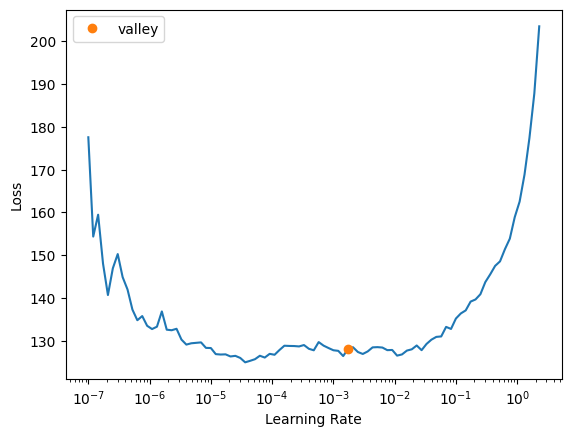

In [9]:
# Find LR
learn.lr_find()

In [10]:
# Set LR
tc.LR = 1e-3

epoch,train_loss,valid_loss,acc_breed,acc_animal,f1_breed,f1_animal,acc_multi,rmse,mae,time
0,107.335152,81.632912,0.207443,0.769814,0.191036,0.716549,0.172984,88.192979,72.266624,01:20
1,86.586174,61.471062,0.268091,0.775327,0.254482,0.721689,0.235010,76.131802,61.967686,01:24
2,66.768188,47.096996,0.314266,0.800138,0.307743,0.761975,0.284631,66.134339,54.327080,01:23
3,60.351509,46.089382,0.308063,0.795314,0.300918,0.750312,0.269469,65.392047,53.689740,01:22


Better model found at epoch 0 with acc_multi value: 0.1729841488628532.


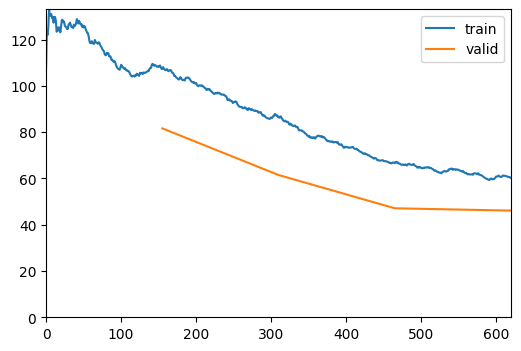

Better model found at epoch 1 with acc_multi value: 0.23501033769813923.
Better model found at epoch 2 with acc_multi value: 0.284631288766368.


In [11]:
# Train
learn.unfreeze()
learn.fit_one_cycle(tc.EPOCHS, slice(tc.LR/100, tc.LR), pct_start=0.3, div=5.0, cbs=tc.CALLBACKS)

# Evaluation

c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings

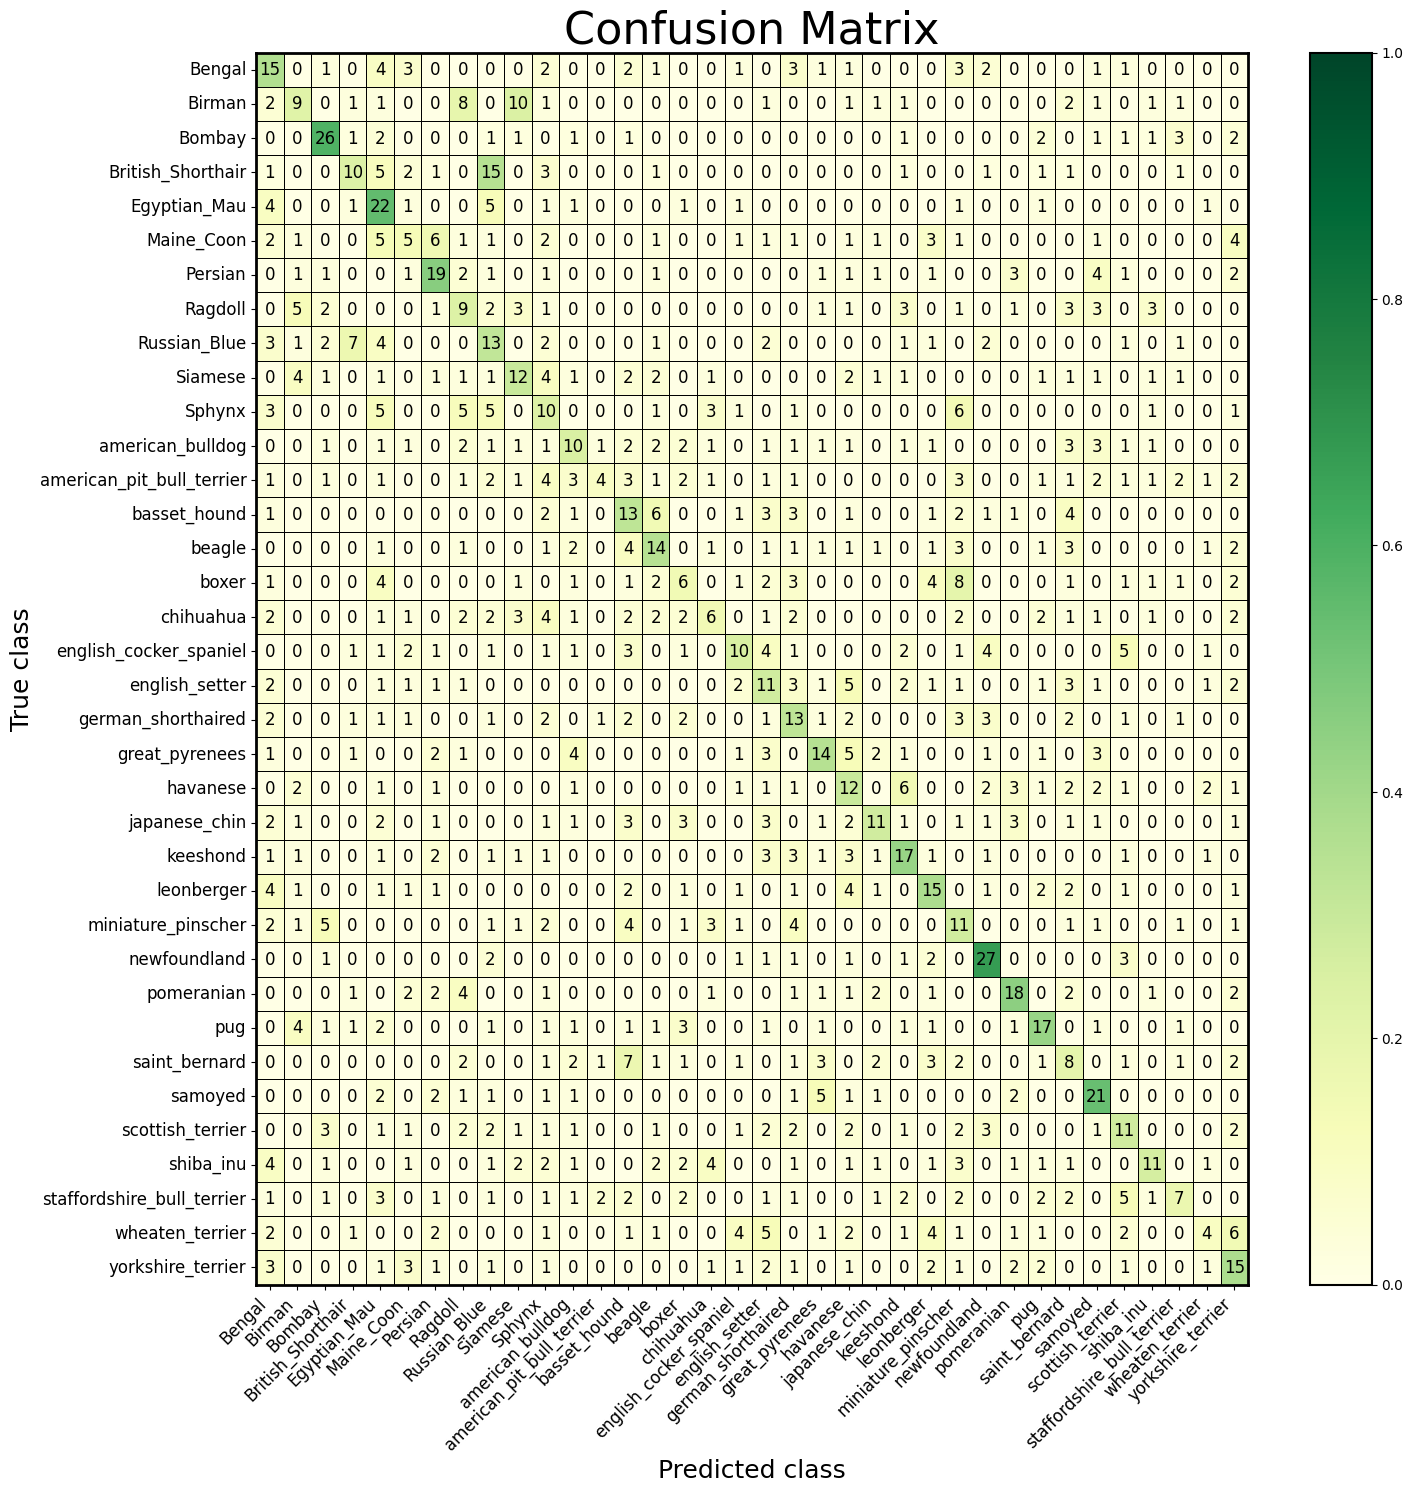

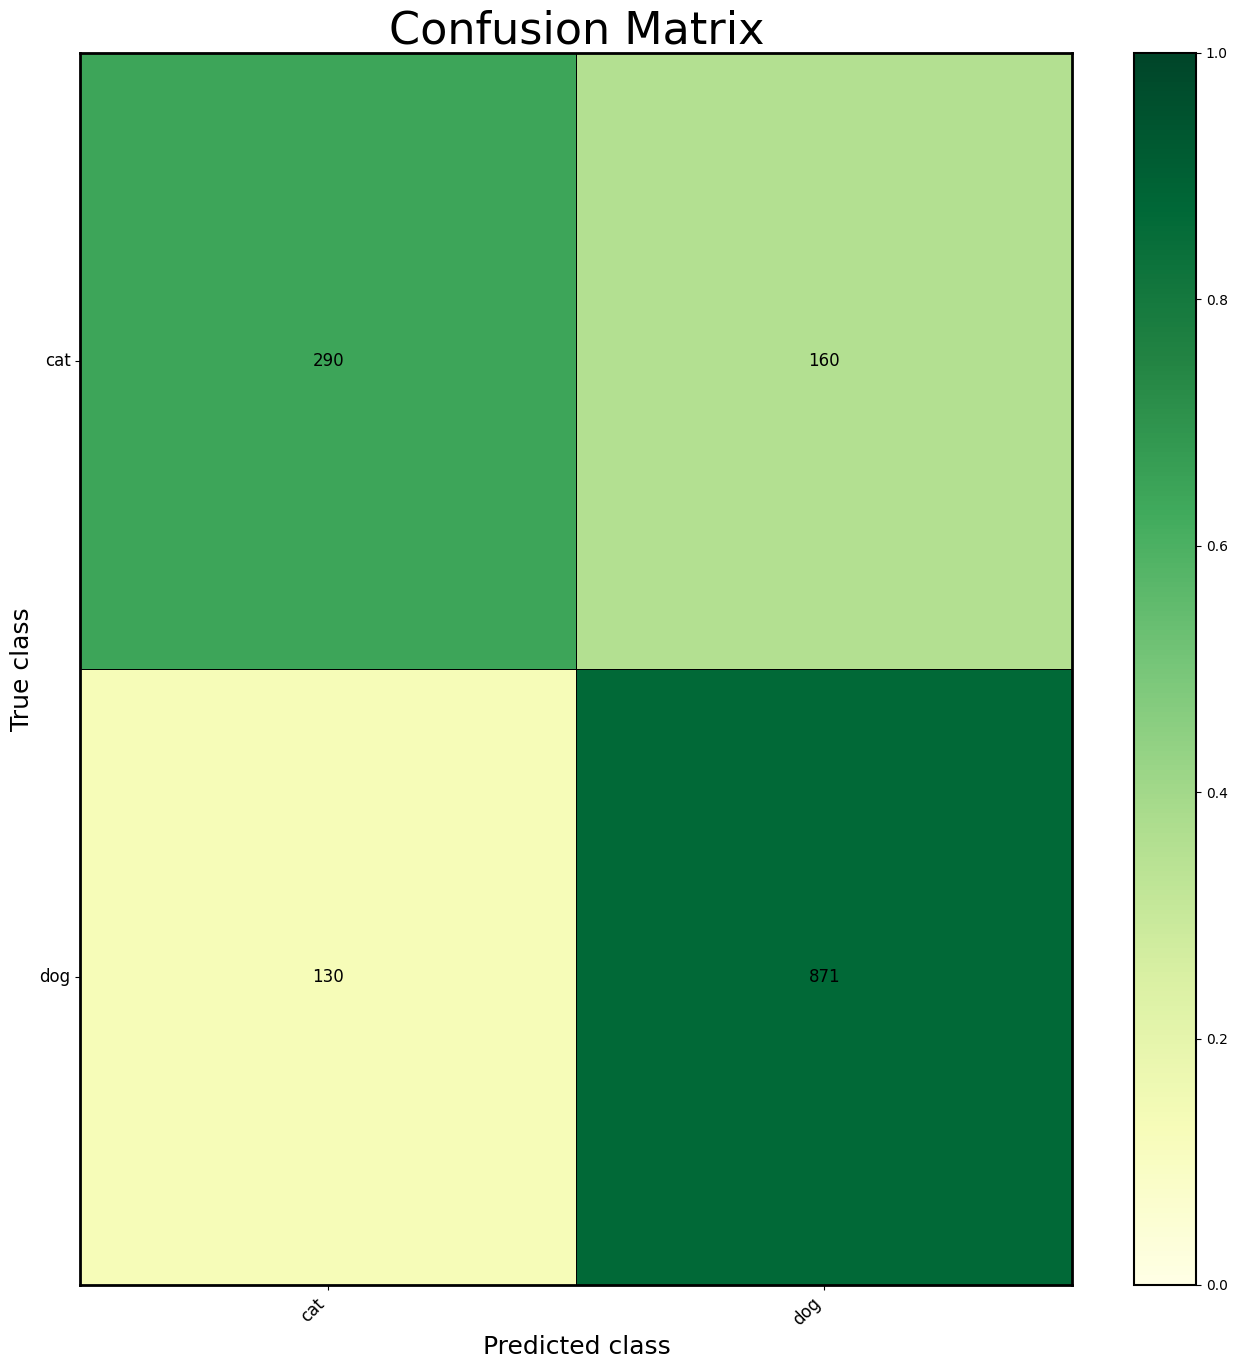

In [12]:
# Create predictions dataframes and confusion matrices
valid_preds = ec.create_predictions_df(learn, learn.dls.valid, dataset_dir+'/')
train_preds = ec.create_predictions_df(learn, learn.dls.train, dataset_dir+'/')
plt_cms, wandb_cms, names_cms = ec.create_confusion_matrices(valid_preds, dls.vocab)

# Logs

In [13]:
def remove_readonly(func, path, _):
    "Clear the readonly bit and reattempt the removal"
    os.chmod(path, stat.S_IWRITE)
    func(path)

In [14]:
# Log final metrics
names = [m.name for m in learn.metrics]
values = learn.validate()[1:]
for n,v in zip(names,values):
    run.summary[n] = v

# Log model
learn.export('models/model.pkl', pickle_module=dill)
run.log_model('models/model.pkl', 'model')
shutil.rmtree('models', onexc=remove_readonly)

# Log wandb confusion matrices
for cm, n in zip(wandb_cms, names_cms):
	wandb.log({n: cm})

c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Facu\miniconda3\envs\projects\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings

In [15]:
# Create evaluation artifact
evaluation_artifact = wandb.Artifact('evaluation', type='evaluation')

# Save dataframes and plt confusion matrices to temporary files and add them to the artifact
with tempfile.TemporaryDirectory() as temp_dir:
	valid_preds.to_csv(temp_dir+'/valid_preds.csv', index=False)
	train_preds.to_csv(temp_dir+'/train_preds.csv', index=False)
	evaluation_artifact.add_file(temp_dir+'/valid_preds.csv', name='valid_preds.csv')
	evaluation_artifact.add_file(temp_dir+'/train_preds.csv', name='train_preds.csv')
	for cm, n in zip(plt_cms, names_cms):
		cm.savefig(temp_dir+f'/{n}.png', bbox_inches='tight')
		evaluation_artifact.add_file(temp_dir+f'/{n}.png', name=f'{n}.png')

# Create and log wandb table referencing local files
table = wandb.Table(columns=['image']+list(valid_preds.columns.values))
for _, row in valid_preds.iterrows():
	local_path = dataset_dir+'/'+ row['file_path']
	table.add_data(
		wandb.Image(local_path),
		*row.values
	)
evaluation_artifact.add(table, 'evaluation_table')

# Log artifact and finish run
run.log_artifact(evaluation_artifact)
run.finish()

acc_animal,▁▂█▇
acc_breed,▁▅██
acc_multi,▁▅█▇
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_animal,▁▂█▆
f1_breed,▁▅██
lr_0,▂▂▃▄▅▇▇▇████████▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▁▁▁▁▁
lr_1,▂▂▃▃▃▄▄▇▇▇████████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▂▂▂▁▁
mae,█▄▁▁


In [25]:
learn.dls.vocab[0]

['Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [19]:
one_batch[0].shape

torch.Size([32, 3, 64, 64])

In [24]:
dls.after_batch[1]

Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
(Tabular,object) -> encodes
decodes: (TensorImage,object) -> decodes
(Tabular,object) -> decodes